In [51]:
# Importação das bibliotecas necessárias
import spacy
import re
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [54]:
path = "data/sentenças_educacao.xlsx"

docs = list(pd.read_excel(path)[1])

# Part 1 - LLM

## Input de Docs com prompt
Input dos docs em um modelo LLM com prompt dedicado a clusterizar os textos da melhor forma possível explicando cada tópico e dando output do número de tópicos.

In [52]:
# Will be applied after due to cost of running an LLM locally

# Will be assumed a that the LLM will output 8 clusters of topics

In [53]:
# Output do LLM será inserido aqui
llm_guess = 8

# Part 2 - LDA

In [55]:
custom_words = {
    "alguns",
    "pouco",
    "muito",
    "toda",
    "todo",
    "algum",
    "certo",
    "vários",
    "nenhum",
    "tanto",
    "quanto",
    "tudo",
    "nada",
    "todo",
}

In [56]:
# Carregar o modelo de linguagem Português
nlp = spacy.load("pt_core_news_sm")

# Configurações adicionais para o spaCy
nlp.Defaults.stop_words |= custom_words  # Adicionando stopwords personalizadas

In [57]:
def limpar_texto(texto):
    # Remover tags HTML
    texto = re.sub(r"<.*?>", "", texto)
    # Remover pontuações e números
    texto = re.sub(r"[^\w\s]", "", texto)
    # Remover espaços extras
    texto = re.sub(r"\s+", " ", texto)
    # Remover quaisquer caracteres não imprimíveis
    texto = re.sub(r"[^\x00-\x7F]+", " ", texto)
    return texto

In [58]:
def preprocessar_texto(texto):
    # Aplicar limpeza inicial
    texto_limpo = limpar_texto(texto)
    # Processar texto com spaCy
    doc = nlp(texto_limpo)
    # Tokenização, remoção de stopwords e lematização
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.text.lower() not in STOP_WORDS
        and not token.is_punct
        and not token.is_space
    ]
    return tokens

In [59]:
def vetorizar_tfidf(corpus):
    # Inicializar o vetorizador TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    # Transformar os documentos em uma matriz TF-IDF
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    return tfidf_matrix, tfidf_vectorizer

In [60]:
# Aplicar a função de pré-processamento a cada documento no conjunto de dados
corpus_preprocessado = [preprocessar_texto(doc) for doc in docs]

dicionario = Dictionary(corpus_preprocessado)
dicionario.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

corpus = [dicionario.doc2bow(doc) for doc in corpus_preprocessado]

corpus_tfidf = ["".join(doc) for doc in corpus_preprocessado]

# Vetorizar o corpus
tfidf_matrix, tfidf_vectorizer = vetorizar_tfidf(corpus_tfidf)

# Exibindo os resultados (opcional, para verificação)
print("Matriz TF-IDF:\n", tfidf_matrix.toarray())

Matriz TF-IDF:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.70710678 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [61]:
# Contar frequências de documento
def frequencia_documento(corpus, dictionary):
    doc_freqs = list(dictionary.dfs.values())
    plt.figure(figsize=(10, 5))
    plt.hist(doc_freqs, bins=100, log=True)  # Log scale para melhor visualização
    plt.xlabel("Frequência Documental")
    plt.ylabel("Número de Palavras")
    plt.title("Distribuição da Frequência Documental das Palavras")
    plt.show()

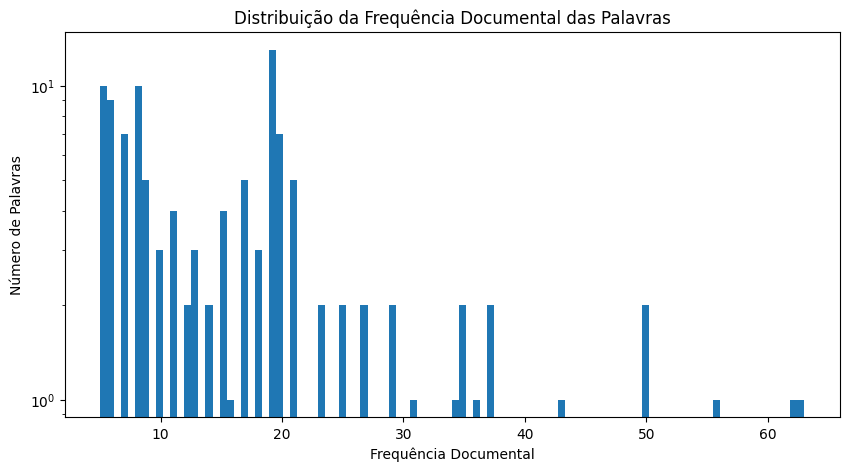

In [62]:
frequencia_documento(corpus, dicionario)

In [63]:
def calcular_derivada_segunda(y_vals, x_vals):
    # Calcular primeiras diferenças
    primeiras_dif = np.diff(y_vals) / np.diff(x_vals)

    # Calcular segundas diferenças (derivada segunda)
    segundas_dif = np.diff(primeiras_dif) / np.diff(x_vals[:-1])

    return segundas_dif

In [64]:
# Função para calcular e plotar o método do cotovelo para LDA
def calcular_metodo_cotovelo(data, max_topics, vectorizer):
    log_likelihood_values = []
    k_range = range(1, max_topics + 1)

    for k in k_range:
        lda_model = LDA(n_components=k, learning_method="online", random_state=42)
        lda_model.fit(data)
        log_likelihood = lda_model.score(data)
        log_likelihood_values.append(log_likelihood)

    # Identificar o ponto de cotovelo usando a segunda derivada
    segundo_dif = calcular_derivada_segunda(
        np.array(log_likelihood_values), np.array(list(k_range))
    )
    ponto_cotovelo = (
        np.argmin(segundo_dif) + 2
    )  # +2 para ajustar o índice após as diferenças

    # Plotar o gráfico com a linha vertical no ponto de cotovelo
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, log_likelihood_values, marker="o")
    plt.title("Método do Cotovelo para Determinar Número Ótimo de Tópicos")
    plt.xlabel("Número de Tópicos")
    plt.ylabel("Log-Likelihood")
    plt.axvline(
        x=ponto_cotovelo,
        color="r",
        linestyle="--",
        label=f"Ponto de Cotovelo: {ponto_cotovelo}",
    )
    plt.legend()
    plt.show()

    return log_likelihood_values, ponto_cotovelo

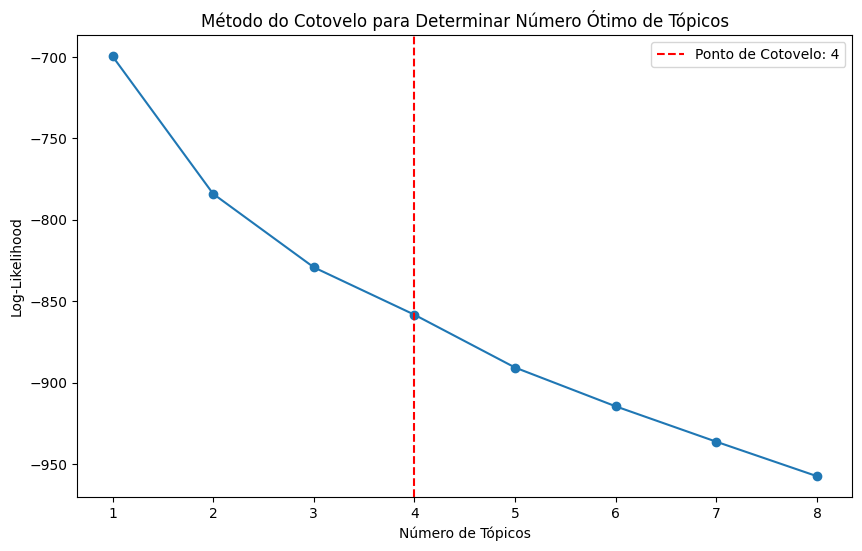

In [65]:
# Assumindo que tfidf_matrix é a matriz TF-IDF gerada no Passo 2
max_topics = (
    llm_guess  # Define o número máximo de tópicos a considerar baseado no input do LLM
)
# Suponha que tfidf_matrix seja sua matriz TF-IDF
log_likelihood_values, ponto_cotovelo = calcular_metodo_cotovelo(
    tfidf_matrix, max_topics, tfidf_vectorizer
)

In [66]:
# Função para configurar e treinar o modelo LDA
def treinar_lda(corpus=corpus, num_topics=ponto_cotovelo, dicionario=dicionario):
    # Configurar e treinar o modelo LDA
    lda_model = LdaModel(
        corpus=corpus,
        num_topics=num_topics,
        id2word=dicionario,
        passes=10,
        random_state=42,
        iterations=50,
        alpha="auto",
        eta="auto",
    )

    return lda_model, dicionario, corpus

In [67]:
# Assumindo corpus_preprocessado é uma lista de documentos tokenizados
num_topics = ponto_cotovelo  # O número ideal obtido a partir do método do cotovelo
lda_model, dictionary, corpus_bow = treinar_lda(corpus, num_topics)

In [68]:
# Função para print os tópicos com as palavras mais significativas
def print_topicos(lda_model, num_palavras=10):
    topics = lda_model.print_topics(num_words=num_palavras)
    for topic in topics:
        print(topic)

In [69]:
# Print tópicos
print_topicos(lda_model)

(0, '0.071*"advocaticio" + 0.058*"valer" + 0.056*"20" + 0.052*"ter" + 0.049*"observar" + 0.045*"aduzir" + 0.041*"98" + 0.040*"condenacao" + 0.039*"causa" + 0.037*"3o"')
(1, '0.050*"publico" + 0.038*"r" + 0.037*"relator" + 0.036*"presente" + 0.036*"termos" + 0.036*"voto" + 0.035*"fazendar" + 0.034*"julgamento" + 0.033*"ministerio" + 0.031*"dano"')
(2, '0.120*"nao" + 0.045*"darlhe" + 0.042*"termos" + 0.040*"voto" + 0.038*"dano" + 0.037*"relator" + 0.033*"autor" + 0.033*"exmo" + 0.033*"moral" + 0.031*"parcial"')
(3, '0.062*"data" + 0.061*"publicacao" + 0.033*"rio" + 0.033*"janeiro" + 0.032*"capital" + 0.032*"justica" + 0.031*"tribunal" + 0.031*"114192006" + 0.031*"4o" + 0.031*"ano"')


In [70]:
# Função para aplicar PCA e plotar os resultados
def aplicar_pca(matriz_tfidf, num_componentes=2):
    # Inicializar e aplicar PCA
    pca = PCA(n_components=num_componentes)
    componentes_principais = pca.fit_transform(
        matriz_tfidf.toarray()
    )  # Converte a matriz TF-IDF para array, se necessário

    # Plotar os componentes principais
    plt.figure(figsize=(8, 6))
    plt.scatter(
        componentes_principais[:, 0],
        componentes_principais[:, 1],
        c="goldenrod",
        alpha=0.5,
    )
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title("Visualização PCA dos Tópicos")
    plt.show()

    return componentes_principais

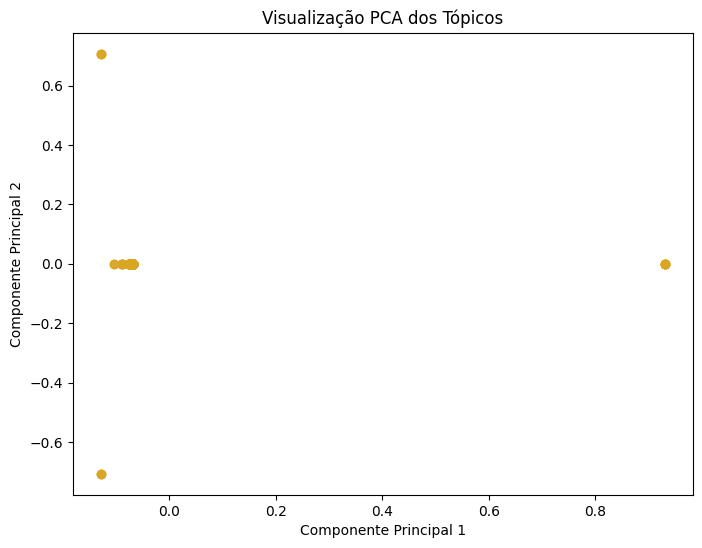

In [71]:
# Supondo que `tfidf_matrix` é a matriz TF-IDF obtida anteriormente
componentes_principais = aplicar_pca(tfidf_matrix, num_componentes=2)

In [72]:
# Função para calcular a coerência dos tópicos
def calcular_coerencia(lda_model, textos, dicionario, corpus):
    # Configurar o modelo de coerência
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=textos,
        dictionary=dicionario,
        corpus=corpus,
        coherence="c_v",
    )

    # Calcular a coerência
    coherence_score = coherence_model.get_coherence()
    print("Coerência do Tópico: ", coherence_score)
    return coherence_score

In [73]:
# Função para interpretar os tópicos gerados
def interpretar_topicos(lda_model, num_topics):
    topics = lda_model.print_topics(num_words=10)
    for i, topic in enumerate(topics):
        print(f"Tópico {i+1}:")
        print(topic[1], "\n")

In [74]:
# Executando a interpretação temática
interpretar_topicos(lda_model, num_topics)

Tópico 1:
0.071*"advocaticio" + 0.058*"valer" + 0.056*"20" + 0.052*"ter" + 0.049*"observar" + 0.045*"aduzir" + 0.041*"98" + 0.040*"condenacao" + 0.039*"causa" + 0.037*"3o" 

Tópico 2:
0.050*"publico" + 0.038*"r" + 0.037*"relator" + 0.036*"presente" + 0.036*"termos" + 0.036*"voto" + 0.035*"fazendar" + 0.034*"julgamento" + 0.033*"ministerio" + 0.031*"dano" 

Tópico 3:
0.120*"nao" + 0.045*"darlhe" + 0.042*"termos" + 0.040*"voto" + 0.038*"dano" + 0.037*"relator" + 0.033*"autor" + 0.033*"exmo" + 0.033*"moral" + 0.031*"parcial" 

Tópico 4:
0.062*"data" + 0.061*"publicacao" + 0.033*"rio" + 0.033*"janeiro" + 0.032*"capital" + 0.032*"justica" + 0.031*"tribunal" + 0.031*"114192006" + 0.031*"4o" + 0.031*"ano" 



In [75]:
# Função para ajustar os parâmetros do modelo LDA e re-treinar
def ajustar_e_treinar_lda(corpus, dicionario, num_topicos, passes, alpha, eta):
    # Reconfigurar e treinar o modelo LDA com novos parâmetros
    lda_model_ajustado = LdaModel(
        corpus=corpus,
        num_topics=num_topicos,
        id2word=dicionario,
        passes=passes,
        alpha=alpha,
        eta=eta,
        random_state=42,
        iterations=50,
    )
    return lda_model_ajustado

In [76]:
# Exemplo de ajuste de parâmetros e re-treinamento
num_topicos_ajustado = 5  # Ajustado baseado na análise anterior
passes_ajustados = 20  # Aumentar o número de passagens para melhor convergência
alpha_ajustado = "symmetric"  # Ajustar a densidade dos tópicos
eta_ajustado = "auto"  # Permitir que o modelo otimize eta

# Aplicando ajustes
lda_model_ajustado = ajustar_e_treinar_lda(
    corpus_bow,
    dictionary,
    num_topicos_ajustado,
    passes_ajustados,
    alpha_ajustado,
    eta_ajustado,
)

# Avaliar novamente a coerência
coerencia_ajustada = calcular_coerencia(
    lda_model_ajustado, corpus_preprocessado, dictionary, corpus_bow
)
print("Coerência do Tópico após ajustes: ", coerencia_ajustada)

# Reinterpretar os tópicos
interpretar_topicos(lda_model_ajustado, num_topicos_ajustado)

Coerência do Tópico:  0.4901346100978505
Coerência do Tópico após ajustes:  0.4901346100978505
Tópico 1:
0.184*"valer" + 0.142*"20" + 0.140*"ter" + 0.126*"condenacao" + 0.126*"aduzir" + 0.124*"advocaticio" + 0.019*"execucao" + 0.007*"janeiro" + 0.007*"rio" + 0.007*"publico" 

Tópico 2:
0.045*"publico" + 0.039*"dano" + 0.035*"relator" + 0.034*"presente" + 0.033*"fazendar" + 0.032*"r" + 0.032*"termos" + 0.032*"voto" + 0.031*"ministerio" + 0.031*"julgamento" 

Tópico 3:
0.157*"nao" + 0.058*"termos" + 0.053*"voto" + 0.051*"jecs" + 0.050*"darlhe" + 0.045*"relator" + 0.043*"autor" + 0.043*"exmo" + 0.043*"julgar" + 0.035*"ja" 

Tópico 4:
0.070*"data" + 0.069*"publicacao" + 0.037*"capital" + 0.037*"janeiro" + 0.037*"rio" + 0.036*"1a" + 0.035*"tribunal" + 0.035*"114192006" + 0.035*"4o" + 0.035*"iii" 

Tópico 5:
0.061*"observar" + 0.057*"advocaticio" + 0.052*"98" + 0.049*"3o" + 0.048*"causa" + 0.042*"processo" + 0.035*"civil" + 0.035*"codigo" + 0.035*"10" + 0.032*"20" 

